# Process National Wetland Inventory data for input into SLAMM

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rx
from shapely.geometry import box

Read in the data

In [2]:
# data paths
RAW_DATA = "../data/raw/"
CLEAN_DATA = "../data/clean/"

In [11]:
# Read in the saltmarsh buffers
cc1_buffer = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/CC-1_buffer.shp") 
ma2_buffer = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/MA-2_buffer.shp") 
ri2_buffer = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/ri2_vegtype.shp") 

# Read in NWI
ri_nwi= gpd.read_file(RAW_DATA + "nwi/RI_shapefile_wetlands/RI_Wetlands.shp")
ma_nwi= gpd.read_file(RAW_DATA + "nwi/MA_shapefile_wetlands/MA_Wetlands.shp")

# crosswalk of NWI to SLAMM categories
nwi_slamm = pd.read_excel(RAW_DATA + "nwi/SLAMM Cowardin NWI code lookup_10.xlsx") 

# SNEP Region
snep_region = gpd.read_file(RAW_DATA + "snep_region/export.shp")

Calculate total acreage of saltmarsh/low tidal/freshwater tidal area in the SNEP region 

In [10]:
ri_ma_nwi = pd.concat([ri_nwi, ma_nwi])
snep_region = snep_region.to_crs(ri_ma_nwi.crs)
snep_nwi = gpd.overlay(ri_ma_nwi, snep_region, how='intersection')

<Axes: >

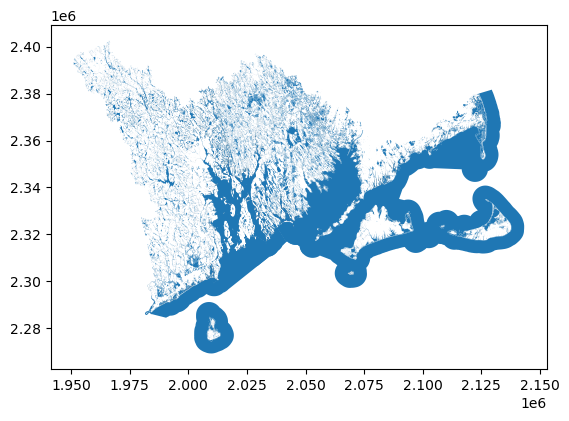

In [11]:
snep_nwi.plot()

In [12]:
snep_nwi.to_file(CLEAN_DATA + "nwi/snep_region_nwi.geojson")

In [3]:
snep_nwi = gpd.read_file(CLEAN_DATA + "nwi/snep_region_nwi.geojson")

In [4]:
snep_nwi_marsh = snep_nwi[snep_nwi.WETLAND_TY.isin(['Estuarine and Marine Wetland'])]
snep_nwi_marsh = snep_nwi_marsh.dissolve(by = 'WETLAND_TY')
snep_nwi_marsh

,geometry,ATTRIBUTE,ACRES,Shape_Leng_1,Shape_Area_1,Id,Shape_Leng_2,Shape_Area_2
WETLAND_TY,,,,,,,,
Estuarine and Marine Wetland,"MULTIPOLYGON (((1982038.02270 2286277.22970, 1...",E2EM1P,0.782255,370.742362,3165.67476,0,33.628732,0.508394


<Axes: >

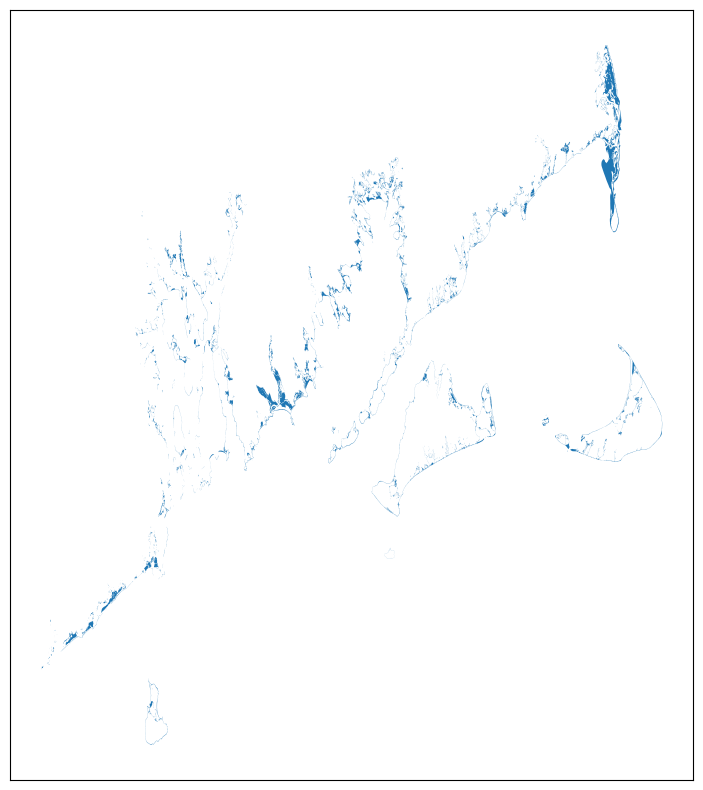

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
snep_nwi_marsh.plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax

In [35]:
snep_nwi_marsh['area_m2'] = snep_nwi_marsh.geometry.area
snep_nwi_marsh['area_acres'] = snep_nwi_marsh['area_m2']/4047
snep_nwi_marsh

,geometry,ATTRIBUTE,ACRES,Shape_Leng_1,Shape_Area_1,Id,Shape_Leng_2,Shape_Area_2,area_m2,area_acres
WETLAND_TY,,,,,,,,,,
Estuarine and Marine Wetland,"MULTIPOLYGON (((1982038.023 2286277.230, 19820...",E2EM1P,0.782255,370.742362,3165.67476,0,33.628732,0.508394,1.595715e+08,39429.580509


Check Image Year for NWI

In [ ]:
ri2_marsh = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/ri2_vegtype.shp") 

In [21]:
import matplotlib.pyplot as plt
import contextily as cx

In [ ]:
ma_nwi_info= gpd.read_file(RAW_DATA + "nwi/MA_shapefile_wetlands/MA_Wetlands_Project_Metadata.shp")
ri_nwi_info= gpd.read_file(RAW_DATA + "nwi/RI_shapefile_wetlands/RI_Wetlands_Project_Metadata.shp")

In [ ]:
ma_nwi_info.head()

In [ ]:
ma_nwi_info_filt = ma_nwi_info[ma_nwi_info["IMAGE_YR"] > 2000]
ma_nwi_info_filt.IMAGE_YR = ma_nwi_info_filt.IMAGE_YR.astype(str)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ma_nwi_info_filt.plot(ax = ax, column = "IMAGE_YR", legend = True)

In [6]:
ri_nwi_info.IMAGE_YR = ri_nwi_info.IMAGE_YR.astype(str)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ri_nwi_info.plot(ax = ax, column = "IMAGE_YR", legend = True)

Clean NWI -> SLAMM conversion data

In [16]:
# simplify slamm conversion df
nwi_slamm_simp = nwi_slamm[["NWI ATTRIBUTE", "SLAMMCODE"]]
nwi_slamm_simp.rename(columns={'NWI ATTRIBUTE': 'ATTRIBUTE'}, inplace=True)
nwi_slamm_simp.head(5)

C:\Users\AMarley.ERG\AppData\Local\Temp\ipykernel_30740\3636481639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nwi_slamm_simp.rename(columns={'NWI ATTRIBUTE': 'ATTRIBUTE'}, inplace=True)


,ATTRIBUTE,SLAMMCODE
0,E1AB,17
1,E1AB1,17
2,E1AB1/2,17
3,E1AB12,17
4,E1AB1L,17


In [17]:
# Codes present in the data but that aren't mapped in the SLAMM conversion table
man_slamm_codes_list = [
    
    ["E1UBLx6", 17],
    ["E1UBLh6", 17],
    ["E2EM1/5Pd6", 20],
    ["PUSRd", 22],
    ["L2EM2F", 5],
    ["PEM1Ea", 5],
    ["PSS1/3Ed", 3],
    ["PSS1/3Ex", 3],
    ["PSS1Af", 3],
    ["PSS3/1Ed", 3],
    ["PUB/EM2Hh", 15],
    ["PUB/EM2Hx", 15],
    ["PUB/EM5F", 15],
    ["PUB/FO5Fh", 15],
    ["PUB/FO5H", 15],
    ["PUB/SS5H", 15],
    ["PUBHa", 15],
    ["R1UBTx", 16]
]

# Make dataframe with codes
man_slamm_codes = pd.DataFrame(man_slamm_codes_list, columns=['ATTRIBUTE', 'SLAMMCODE'])
man_slamm_codes


,ATTRIBUTE,SLAMMCODE
0,E1UBLx6,17
1,E1UBLh6,17
2,E2EM1/5Pd6,20
3,PUSRd,22
4,L2EM2F,5
5,PEM1Ea,5
6,PSS1/3Ed,3
7,PSS1/3Ex,3
8,PSS1Af,3
9,PSS3/1Ed,3


In [18]:
# add to SLAMM df
nwi_slamm_simp_all = pd.concat([nwi_slamm_simp, man_slamm_codes])
nwi_slamm_simp_all

,ATTRIBUTE,SLAMMCODE
0,E1AB,17
1,E1AB1,17
2,E1AB1/2,17
3,E1AB12,17
4,E1AB1L,17
...,...,...
13,PUB/FO5Fh,15
14,PUB/FO5H,15
15,PUB/SS5H,15
16,PUBHa,15


Crop NWI to saltmarsh and convert to SLAMM categories

In [ ]:
def crop_nwi(state_nwi, marsh_buffer, nwi_slamm_xwalk, which_crs, which_marsh):
    
    # Add SLAMM code and simplify dataframe
    state_nwi_slamm = state_nwi.merge(nwi_slamm_xwalk, on = 'ATTRIBUTE', how = 'left')
    state_nwi_slamm = state_nwi_slamm[["ATTRIBUTE", "WETLAND_TY", "SLAMMCODE", "geometry"]]

    # Convert buffer polygons to same crs
    state_nwi_slamm_crs = state_nwi_slamm.to_crs(which_crs)
    marsh_buffer_crs = marsh_buffer.to_crs(which_crs)

    # crop state NWI to saltmarsh extent
    marsh_nwi_slamm = state_nwi_slamm_crs.clip(box(*marsh_buffer_crs.total_bounds))
    display(marsh_nwi_slamm.plot())

    # save file
    marsh_nwi_slamm.to_file(CLEAN_DATA + f'nwi/{which_marsh}_nwi.geojson')

    return marsh_nwi_slamm

In [ ]:
ma2_nwi_slamm = crop_nwi(ma_nwi, ma2_buffer, nwi_slamm_simp_all, 3857, 'ma2')
cc1_nwi_slamm = crop_nwi(ma_nwi, cc1_buffer, nwi_slamm_simp_all, 3857, 'cc1')
ri2_nwi_slamm = crop_nwi(ri_nwi, ri2_buffer, nwi_slamm_simp_all, 26918, 'ri2')

Make a version with no natural habitat 

In [17]:
def make_ow(slamm_gdf: gpd.GeoDataFrame):

    slamm_gdf['SLAMMCODE'] = [a if a > 14 and a < 20 
                              else 17 
                              for a in slamm_gdf['SLAMMCODE']]

    return slamm_gdf

In [ ]:
# make an nwi version that is just all open water (slamm code 17)
ri2_nwi_slamm_ow = make_ow(ri2_nwi_slamm)
ri2_nwi_slamm_ow

Make a version where anything that is not already open water or is freshwater nontidal gets converted to open water

In [ ]:
def make_ow_no_fnt(slamm_gdf: gpd.GeoDataFrame, which_marsh: str):

    slamm_gdf_2 = slamm_gdf.copy()
    slamm_gdf_2['SLAMMCODE'] = [a if (a > 0 and a < 6) or (a > 14 and a < 20) or (a == 22) or (a==25)
                              else 17 
                              for a in slamm_gdf_2['SLAMMCODE']]
    
    # save file
    slamm_gdf_2.to_file(CLEAN_DATA + f'nwi/{which_marsh}_nwi_ow_fnt.geojson')

    return slamm_gdf_2

In [ ]:
ri2_nwi_slamm_ow_nft = make_ow_no_fnt(ri2_nwi_slamm, 'ri2')
ma2_nwi_slamm_ow_nft = make_ow_no_fnt(ma2_nwi_slamm, 'ma2')
cc1_nwi_slamm_ow_nft = make_ow_no_fnt(cc1_nwi_slamm, 'cc1')

Rasterize the polygons

Followed this method:
https://www.linkedin.com/pulse/rasterize-polygons-geopandas-geocube-chonghua-yin/


In [ ]:
from geocube.api.core import make_geocube

In [ ]:
def rasterize_slamm_cat(which_marsh: str, open_water: bool):

    if open_water:
        nwi_slamm_path = f'nwi/{which_marsh}_nwi_ow_fnt.geojson'
        output_path = f'nwi/{which_marsh}_nwi_ow_fnt.asc'

    else:
        nwi_slamm_path = f'nwi/{which_marsh}_nwi.geojson'
        output_path = f'nwi/{which_marsh}_nwi.asc'

    # read in the slamm category geodataframe
    nwi_slamm_gdf = gpd.read_file(CLEAN_DATA + nwi_slamm_path)

    # read in the dem raster
    dem = rx.open_rasterio(CLEAN_DATA + f"dem/{which_marsh}_dem.tif")

    # convert to raster
    nwi_slamm_rast = make_geocube(
        vector_data=nwi_slamm_gdf,
        measurements=["SLAMMCODE"],
        like=dem,
        fill = -9999
        )
    
    # plot it
    nwi_slamm_rast["SLAMMCODE"].plot()

    # save to asc
    nwi_slamm_rast.rio.to_raster(CLEAN_DATA + output_path)


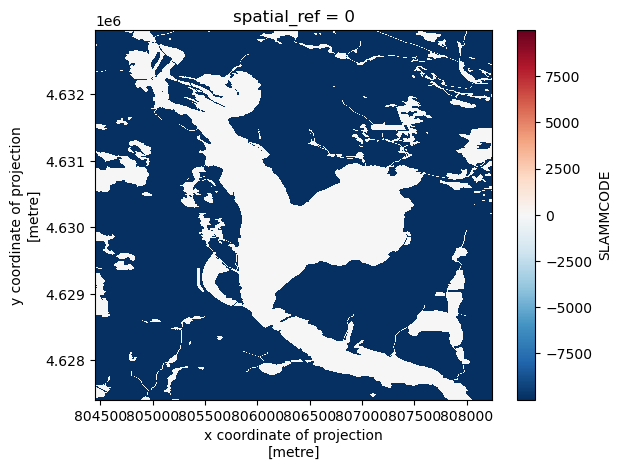

In [11]:
rasterize_slamm_cat('ri2', True)

In [ ]:
rasterize_slamm_cat('cc1', True)